# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt # plot
import pandas as pd
from scipy.integrate import solve_ivp  # to solve ODE system
from scipy.integrate import simps # calculate the yield with Simpson rule
from numpy import trapz # calculate the yield with trapezoid rule
from SALib.sample.morris import sample as ee_sample # sensitivity analysis
from SALib.analyze.morris import analyze as ee_analyze # sensitivity analysis
from tqdm import tqdm
import seaborn as sns # colourful plot

# Numerical parameters

In [2]:
seed = 1234
method = "Radau"
tmax = 300 # 5000 for the numerical continuation, 300 for the time series
step = tmax*10
time_list = np.linspace(0, tmax, step)
num_of_points = 500 # 

# Parameter values

In [3]:
r=0.2
K=10
KBt=190
aL=0.5
hL=1
sL=1
nE=1
aP=0.4
alpha=0.5 # 0<alpha<10
hP=0.1
qL=0.01
nL=0.3
mBt=0.2
bA=1
mA=0.1
mP=0.3
bL=1
bP=1
RP=0
sig=2
bound=3 # economic threshold
P0=0 # parasitoid initial condition

# Parasitoid release

def ddf(t,sig_1,value_1,bound_1): #(t,sig,A,bound)
    val = 0.0
    if value_1>bound_1:
        t_transition=1
        half_life_time=0.2
        decay_constant = np.log(2)/half_life_time
        val = sig_1 * np.exp(-decay_constant * (t - t_transition))
    return val
#inoculative_function = ddf

In [4]:
def ddf(t,sig_1,value_1,bound_1): #(t,sig,A,bound)
    val = 0.0
    x0 = P0
    x1 = x0 + sig_1
    w = 0.5
    sigmat = 1.0 / (1.0 + np.exp(-(5 - t) / w))
    if value_1>bound_1:
        val = ( x0 + (x1 - x0)*(1 - sigmat) ) # https://kitchingroup.cheme.cmu.edu/blog/2013/02/27/Smooth-transitions-between-two-constants/
    return val

x=np.linspace(0,10, 500)
value_1=bound+1
y=ddf(x,sig,value_1,bound)

plt.figure(figsize=(9, 7))
plt.plot(x, y, '-')
plt.xlabel('time')
plt.ylabel('Population')

# Mathematical model

In [5]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    KBt=KBt,
    aL=aL,
    hL=hL,
    sL=sL,
    nE=nE,
    aP=aP,
    alpha=alpha,
    hP=hP,
    qL=qL,
    nL=nL,
    mBt=mBt,
    bA=bA,
    mA=mA,
    mP=mP,
    bL=bL,
    bP=bP,
):
    C,CBt,E,EBt,L,LBt,A,P = X
#    C: crop
#    CBt: genetically modified Bt crop
#    E: egg pest
#    EBt: egg pest in CBt
#    L: larvae pest in C
#    LBt: larvae pest in CBt
#    A: adult moth pest
#    P: parasitoid of egg (biocontrol agent)
    C_prime=r*C*(1-C/K)-aL*C*nE*E/(1+hL*C)
    CBt_prime=r*CBt*(1-CBt/KBt)-aL*CBt*nE*EBt/(1+hL*CBt)
    E_prime=(C/(C+CBt))*sL*A-nE*E-aP*(E**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
    EBt_prime=(CBt/(C+CBt))*sL*A-nE*EBt-aP*(EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
    L_prime=bL*aL*C*nE*E/(1+hL*C)-qL*L**2-nL*L
    LBt_prime=bL*aL*CBt*nE*EBt/(1+hL*CBt)-qL*LBt**2-nL*LBt-mBt*LBt
    A_prime=bA*nL*(L+LBt)-mA*A
    RP=ddf(t,sig,A,bound)
    P_prime=bP*aP*(E**alpha+EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)-mP*P+RP
    return C_prime,CBt_prime,E_prime,EBt_prime,L_prime,LBt_prime,A_prime,P_prime

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    KBt=KBt,
    aL=aL,
    hL=hL,
    sL=sL,
    nE=nE,
    aP=aP,
    alpha=alpha,
    hP=hP,
    qL=qL,
    nL=nL,
    mBt=mBt,
    bA=bA,
    mA=mA,
    mP=mP,
    bL=bL,
    bP=bP,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,KBt,aL,hP,sL,nE,aP,alpha,hP,qL,nL,mBt,bA,mA,mP,bL,bP),
        method=method,
    )
    return solution_ODE_structured_parasitism

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

# Initial conditions

In [6]:
y0 = np.array([1, 1, 0, 0, 0, 0, 1, P0]) # C, CBt, E, EBt, L, LBt, A, P

solution_ODE_structured_parasitism = structured_parasitism_ode_solver(y0,(t0, tf + days_to_forecast),time_list,r=r,K=K,KBt=KBt,nE=nE,sL=sL,aP=aP,alpha=alpha,hP=hP,qL=qL,nL=nL,mBt=mBt,bA=bA,mA=mA,mP=mP,bL=bL,bP=bP)
t_computed_structured_parasitism, y_computed_structured_parasitism = solution_ODE_structured_parasitism.t, solution_ODE_structured_parasitism.y
C,CBt,E,EBt,L,LBt,A,P = y_computed_structured_parasitism

In [7]:
print(C[-1], CBt[-1], E[-1], EBt[-1], L[-1], LBt[-1], A[-1], P[-1])

9.98333437467626 179.96934214910758 0.0013321373068741933 0.40116107597416567 0.011087796784128103 3.5485904709504252 10.679052182575022 40.92187957512168


# Area under the curve

In [8]:
print(trapz(C+CBt),simps(C+CBt))

350067.3487613136 350067.3517629601


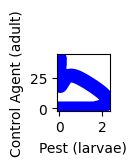

In [9]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.plot(L, P, linestyle="-", linewidth=10, markersize=12,color="b")

plt.xlabel("Pest (larvae)")
plt.ylabel("Control Agent (adult)")
plt.rcParams.update({'font.size': 30})

plt.tight_layout(pad=0)
plt.show()

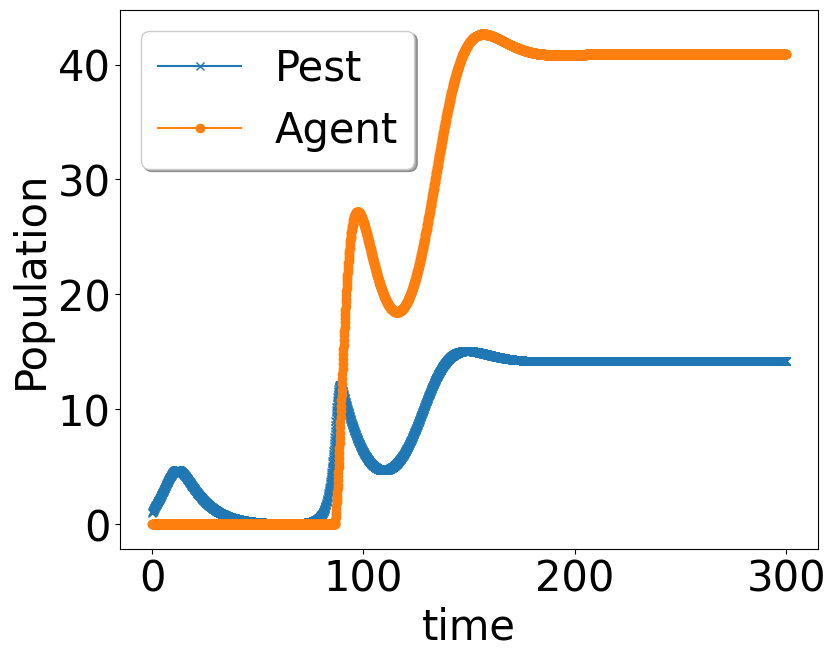

In [10]:
plt.figure(figsize=(9, 7))

plt.plot(time_list, E+L+LBt+A, '-x', label='Pest')
plt.plot(time_list, P, '-o', label='Agent')

plt.xlabel('time')
plt.ylabel('Population')

plt.legend(shadow=True)

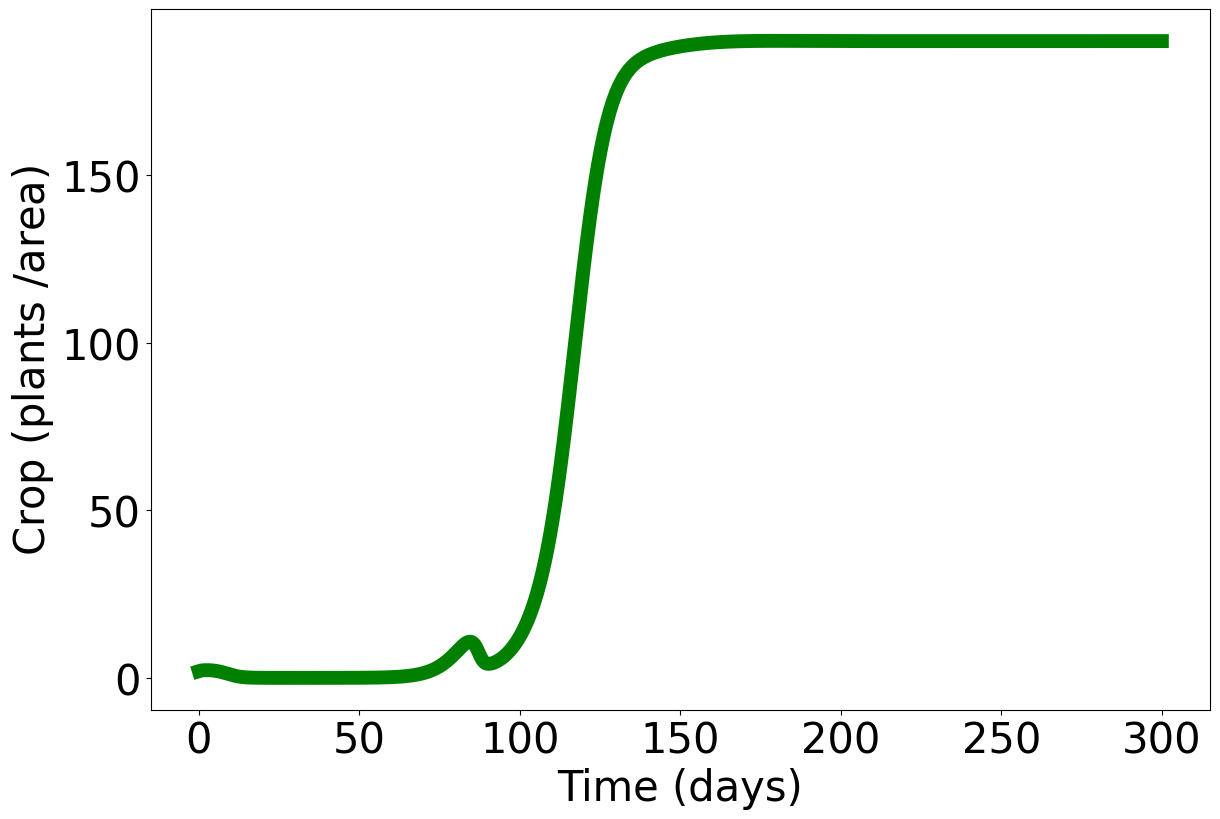

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, C+CBt, linestyle="-", linewidth=10, color="g") #

plt.xlabel("Time (days)")
plt.ylabel("Crop (plants $\mathregular{/area}$)") #ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([155, 205])

plt.tight_layout(pad=0)
#plt.savefig('img/all_mixed_structured_parasitism_resource.png', format='png')
plt.show()

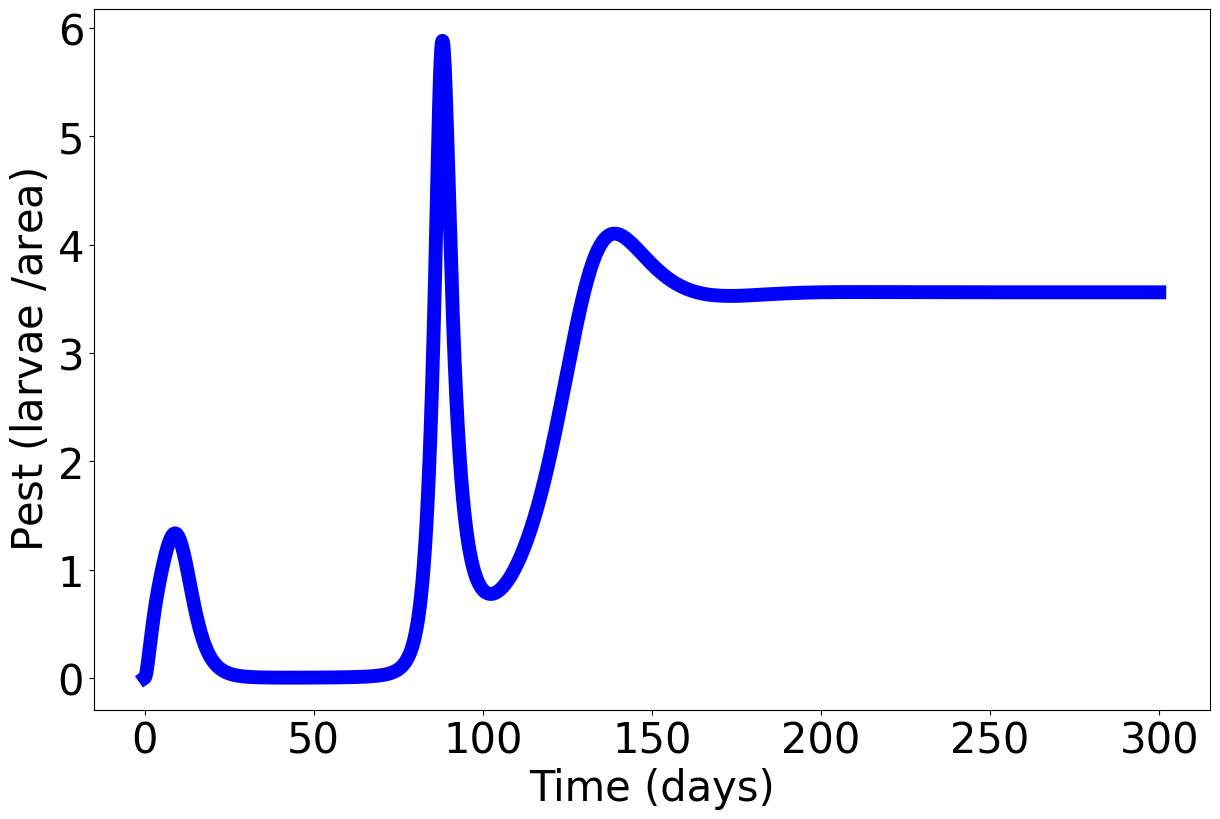

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, L+LBt, linestyle="-", linewidth=10, markersize=12,color="b") #, label="Pest"

plt.xlabel("Time (days)")
plt.ylabel("Pest (larvae $\mathregular{/area}$)") #ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 330])

#plt.savefig('img/all_mixed_structured_parasitism_pest.png', format='png', bbox_inches = 'tight')
plt.tight_layout(pad=0)
plt.show()

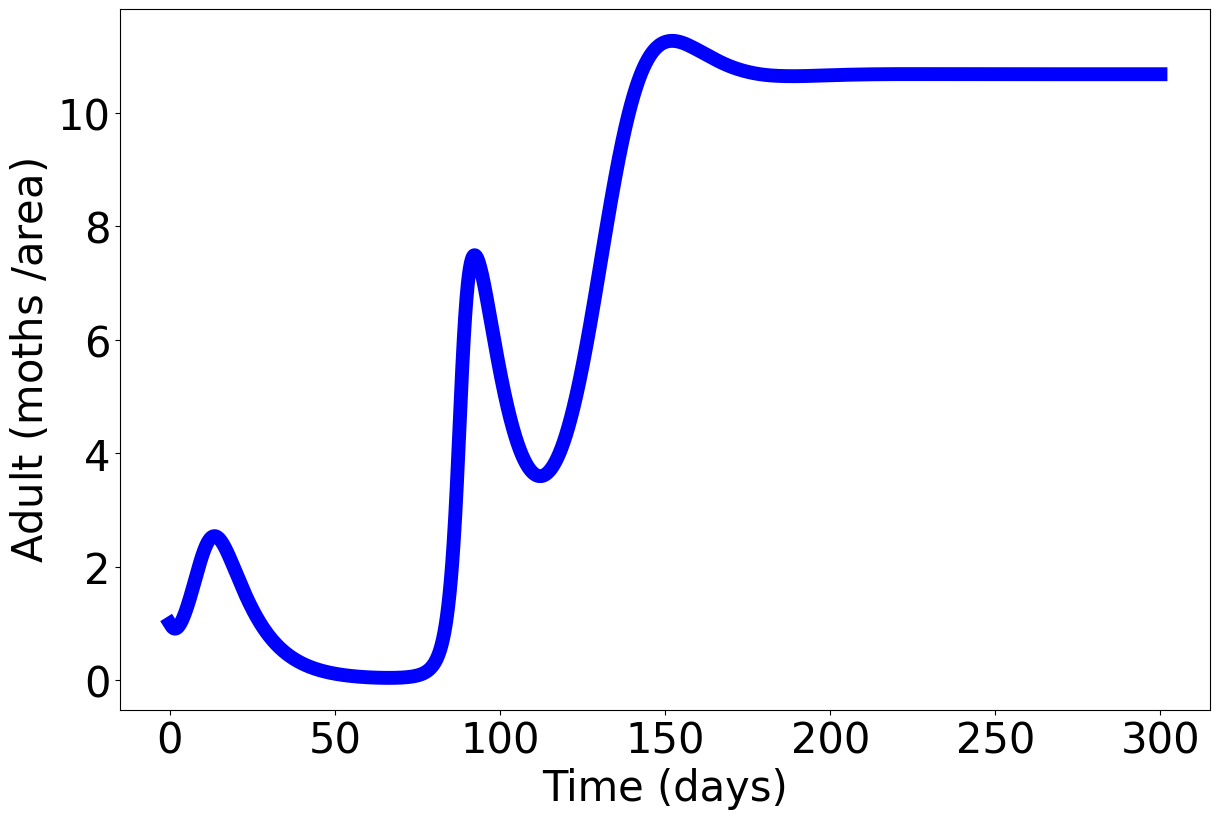

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, A, linestyle="-", linewidth=10, markersize=12,color="b") #, label="Pest"

plt.xlabel("Time (days)")
plt.ylabel("Adult (moths $\mathregular{/area}$)") #ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

#plt.savefig('img/all_mixed_structured_parasitism_pest.png', format='png', bbox_inches = 'tight')
plt.tight_layout(pad=0)
plt.show()

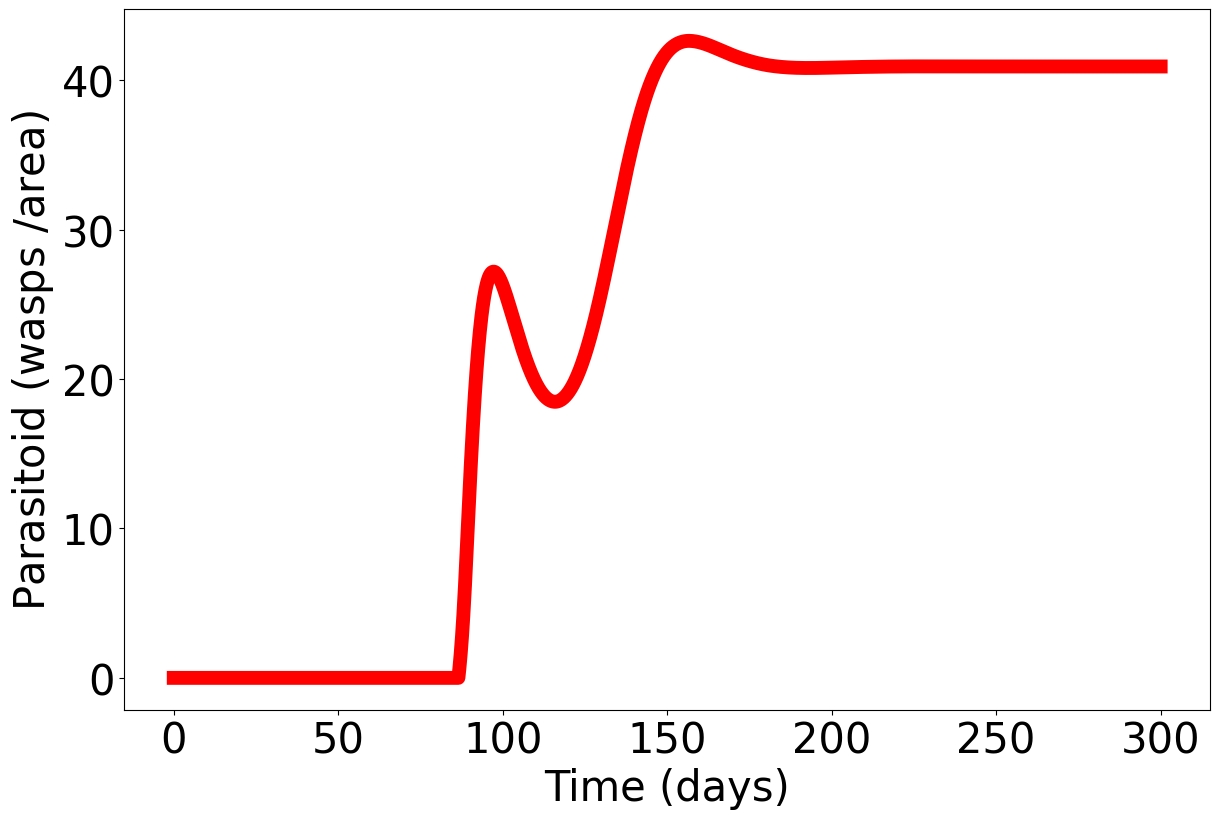

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, P, linestyle="-", linewidth=10, markersize=12,color="r") #, label="Control Agent"

plt.xlabel("Time (days)")
plt.ylabel("Parasitoid (wasps $\mathregular{/area}$)") #ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

#plt.savefig('img/all_mixed_structured_parasitism_agent.png', format='png', bbox_inches = 'tight')
plt.tight_layout(pad=0)
plt.show()

# Sensitivity Analyses

In [15]:
mean_values_params = [
    r,
    K,
    KBt,
    aL,
    hL,
    sL,
    nE,
    aP,
    alpha,
    hP,
    qL,
    nL,
    mBt,
    bA,
    mA,
    mP,
    bL,
    bP,
]
factors_names = [
    r"$\mathregular{r}$",
    r"$\mathregular{K}$",
    r"$\mathregular{K_{Bt}}$",
    r"$\mathregular{a_L}$",
    r"$\mathregular{h_L}$",
    r"$\mathregular{s_L}$",
    r"$\mathregular{n_E}$",
    r"$\mathregular{a_P}$",
    r"$\mathregular{\alpha}$",
    r"$\mathregular{h_P}$",
    r"$\mathregular{q_L}$",
    r"$\mathregular{n_L}$",
    r"$\mathregular{m_{Bt}}$",
    r"$\mathregular{b_A}$",
    r"$\mathregular{m_A}$",
    r"$\mathregular{m_P}$",
    r"$\mathregular{b_L}$",
    r"$\mathregular{b_P}$",
]
params_perturbations = 0.4
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 100
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [16]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameter_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_structured_parasitism = structured_parasitism_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameter_realization
    )
    C_realization,CBt_realization,E_realization,EBt_realization,L_realization,LBt_realization,A_realization,P_realization = realization_ODE_structured_parasitism.y
    
    qoi_sensitivity_outputs[realization_index, :] = (L_realization + LBt_realization)

  0%|                                                    | 0/76 [00:00<?, ?it/s]/tmp/ipykernel_161522/63185712.py:34: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(C/(C+CBt))*sL*A-nE*E-aP*(E**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:35: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(CBt/(C+CBt))*sL*A-nE*EBt-aP*(EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:40: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=bP*aP*(E**alpha+EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)-mP*P+RP
100%|███████████████████████████████████████████| 76/76 [00:04<00:00, 15.98it/s]


In [17]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
#    try:
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs[:, time_list_point], 
        num_levels=grid_level, 
        seed=seed
    )
    # Some parameters combinations may result in simulation failure.
    # This if skip such cases, since they do not have associated sensitivity indicies
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
#    except:
#        continue

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_161522/451572922.py:22: RuntimeWarning: invalid value encountered in true_divide
  sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.26it/s]


,time_list,$\mathregular{r}$,$\mathregular{K}$,$\mathregular{K_{Bt}}$,$\mathregular{a_L}$,$\mathregular{h_L}$,$\mathregular{s_L}$,$\mathregular{n_E}$,$\mathregular{a_P}$,$\mathregular{\alpha}$,$\mathregular{h_P}$,$\mathregular{q_L}$,$\mathregular{n_L}$,$\mathregular{m_{Bt}}$,$\mathregular{b_A}$,$\mathregular{m_A}$,$\mathregular{m_P}$,$\mathregular{b_L}$,$\mathregular{b_P}$
0,3.030303,0.108371,0.007239,0.000279,0.22365,0.0,0.283286,0.066964,0.0,0.0,0.023768,0.000332,0.045061,0.022514,0.008994,0.028007,0.0,0.181535,0.0
1,6.060606,0.211774,0.020224,0.000681,0.151499,0.0,0.191914,0.015375,0.0,0.0,0.014878,0.001201,0.056582,0.031602,0.050452,0.027847,0.0,0.225971,0.0
2,9.090909,0.193373,0.010556,0.001087,0.139289,0.0,0.172789,0.023466,0.005268,0.000293,0.030988,0.001979,0.068525,0.026378,0.099516,0.039506,0.004255,0.16224,0.020491
3,12.121212,0.048314,0.00887,0.000349,0.168087,0.0,0.222366,0.03714,0.003905,0.022078,0.023976,0.003018,0.161355,0.015702,0.080736,0.028154,0.01365,0.134867,0.027433
4,15.151515,0.071433,0.01102,0.000766,0.166407,0.0,0.17038,0.036673,0.001261,0.047339,0.013376,0.003045,0.209428,0.027119,0.072154,0.034836,0.026269,0.071215,0.03728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,287.878788,0.001146,0.007526,0.009718,0.090283,0.0,0.032293,0.078974,0.173386,0.039444,0.067352,0.02666,0.106678,0.028941,0.053713,0.023354,0.096944,0.050969,0.112617
95,290.909091,0.003904,0.007519,0.008889,0.074905,0.0,0.033254,0.08854,0.178356,0.047717,0.053776,0.022492,0.09943,0.029038,0.050634,0.031541,0.099282,0.04894,0.121783
96,293.939394,0.014175,0.007202,0.012478,0.061097,0.0,0.033757,0.09003,0.186111,0.055385,0.045991,0.01898,0.080334,0.028602,0.048068,0.039025,0.0992,0.051088,0.128478
97,296.969697,0.022794,0.006438,0.020874,0.060997,0.0,0.032687,0.084428,0.184228,0.058007,0.04338,0.015712,0.078503,0.026862,0.044564,0.042088,0.093958,0.057848,0.126634


In [18]:
df_sigmai

,time_list,$\mathregular{r}$,$\mathregular{K}$,$\mathregular{K_{Bt}}$,$\mathregular{a_L}$,$\mathregular{h_L}$,$\mathregular{s_L}$,$\mathregular{n_E}$,$\mathregular{a_P}$,$\mathregular{\alpha}$,$\mathregular{h_P}$,$\mathregular{q_L}$,$\mathregular{n_L}$,$\mathregular{m_{Bt}}$,$\mathregular{b_A}$,$\mathregular{m_A}$,$\mathregular{m_P}$,$\mathregular{b_L}$,$\mathregular{b_P}$
0,3.030303,0.240522,0.018452,0.000621,0.205582,0.0,0.106792,0.116441,0.0,0.0,0.027114,0.000787,0.042239,0.064035,0.011304,0.036405,0.0,0.129706,0.0
1,6.060606,0.130429,0.035646,0.00127,0.150768,0.0,0.333399,0.018933,0.0,0.0,0.033442,0.001932,0.030427,0.03128,0.078012,0.012079,0.0,0.142382,0.0
2,9.090909,0.166182,0.007434,0.00138,0.184467,0.0,0.096181,0.040803,0.0129,0.000718,0.048314,0.002137,0.027457,0.015714,0.209681,0.058395,0.006056,0.073484,0.048699
3,12.121212,0.034423,0.008214,0.000775,0.029036,0.0,0.154105,0.022825,0.011539,0.043134,0.027373,0.004441,0.166347,0.025541,0.106005,0.041773,0.027159,0.245364,0.051946
4,15.151515,0.137549,0.012365,0.001777,0.128009,0.0,0.129676,0.038623,0.003702,0.075585,0.018265,0.003908,0.152081,0.04359,0.055829,0.043093,0.049618,0.037023,0.069307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,287.878788,0.001598,0.011572,0.00404,0.045681,0.0,0.028459,0.127546,0.23867,0.040675,0.0843,0.028403,0.121688,0.006969,0.083628,0.012296,0.06118,0.02938,0.073916
95,290.909091,0.00723,0.010723,0.007621,0.041706,0.0,0.029665,0.149216,0.23725,0.041508,0.05926,0.021767,0.116577,0.006892,0.078674,0.021581,0.060136,0.033284,0.076909
96,293.939394,0.026548,0.009393,0.013924,0.050075,0.0,0.029465,0.149029,0.225074,0.041218,0.045341,0.016998,0.112051,0.006443,0.071765,0.032011,0.056149,0.038159,0.076356
97,296.969697,0.041307,0.007969,0.029495,0.056213,0.0,0.028478,0.137584,0.208363,0.040125,0.037561,0.014217,0.112846,0.00586,0.064972,0.038486,0.051117,0.05264,0.072766


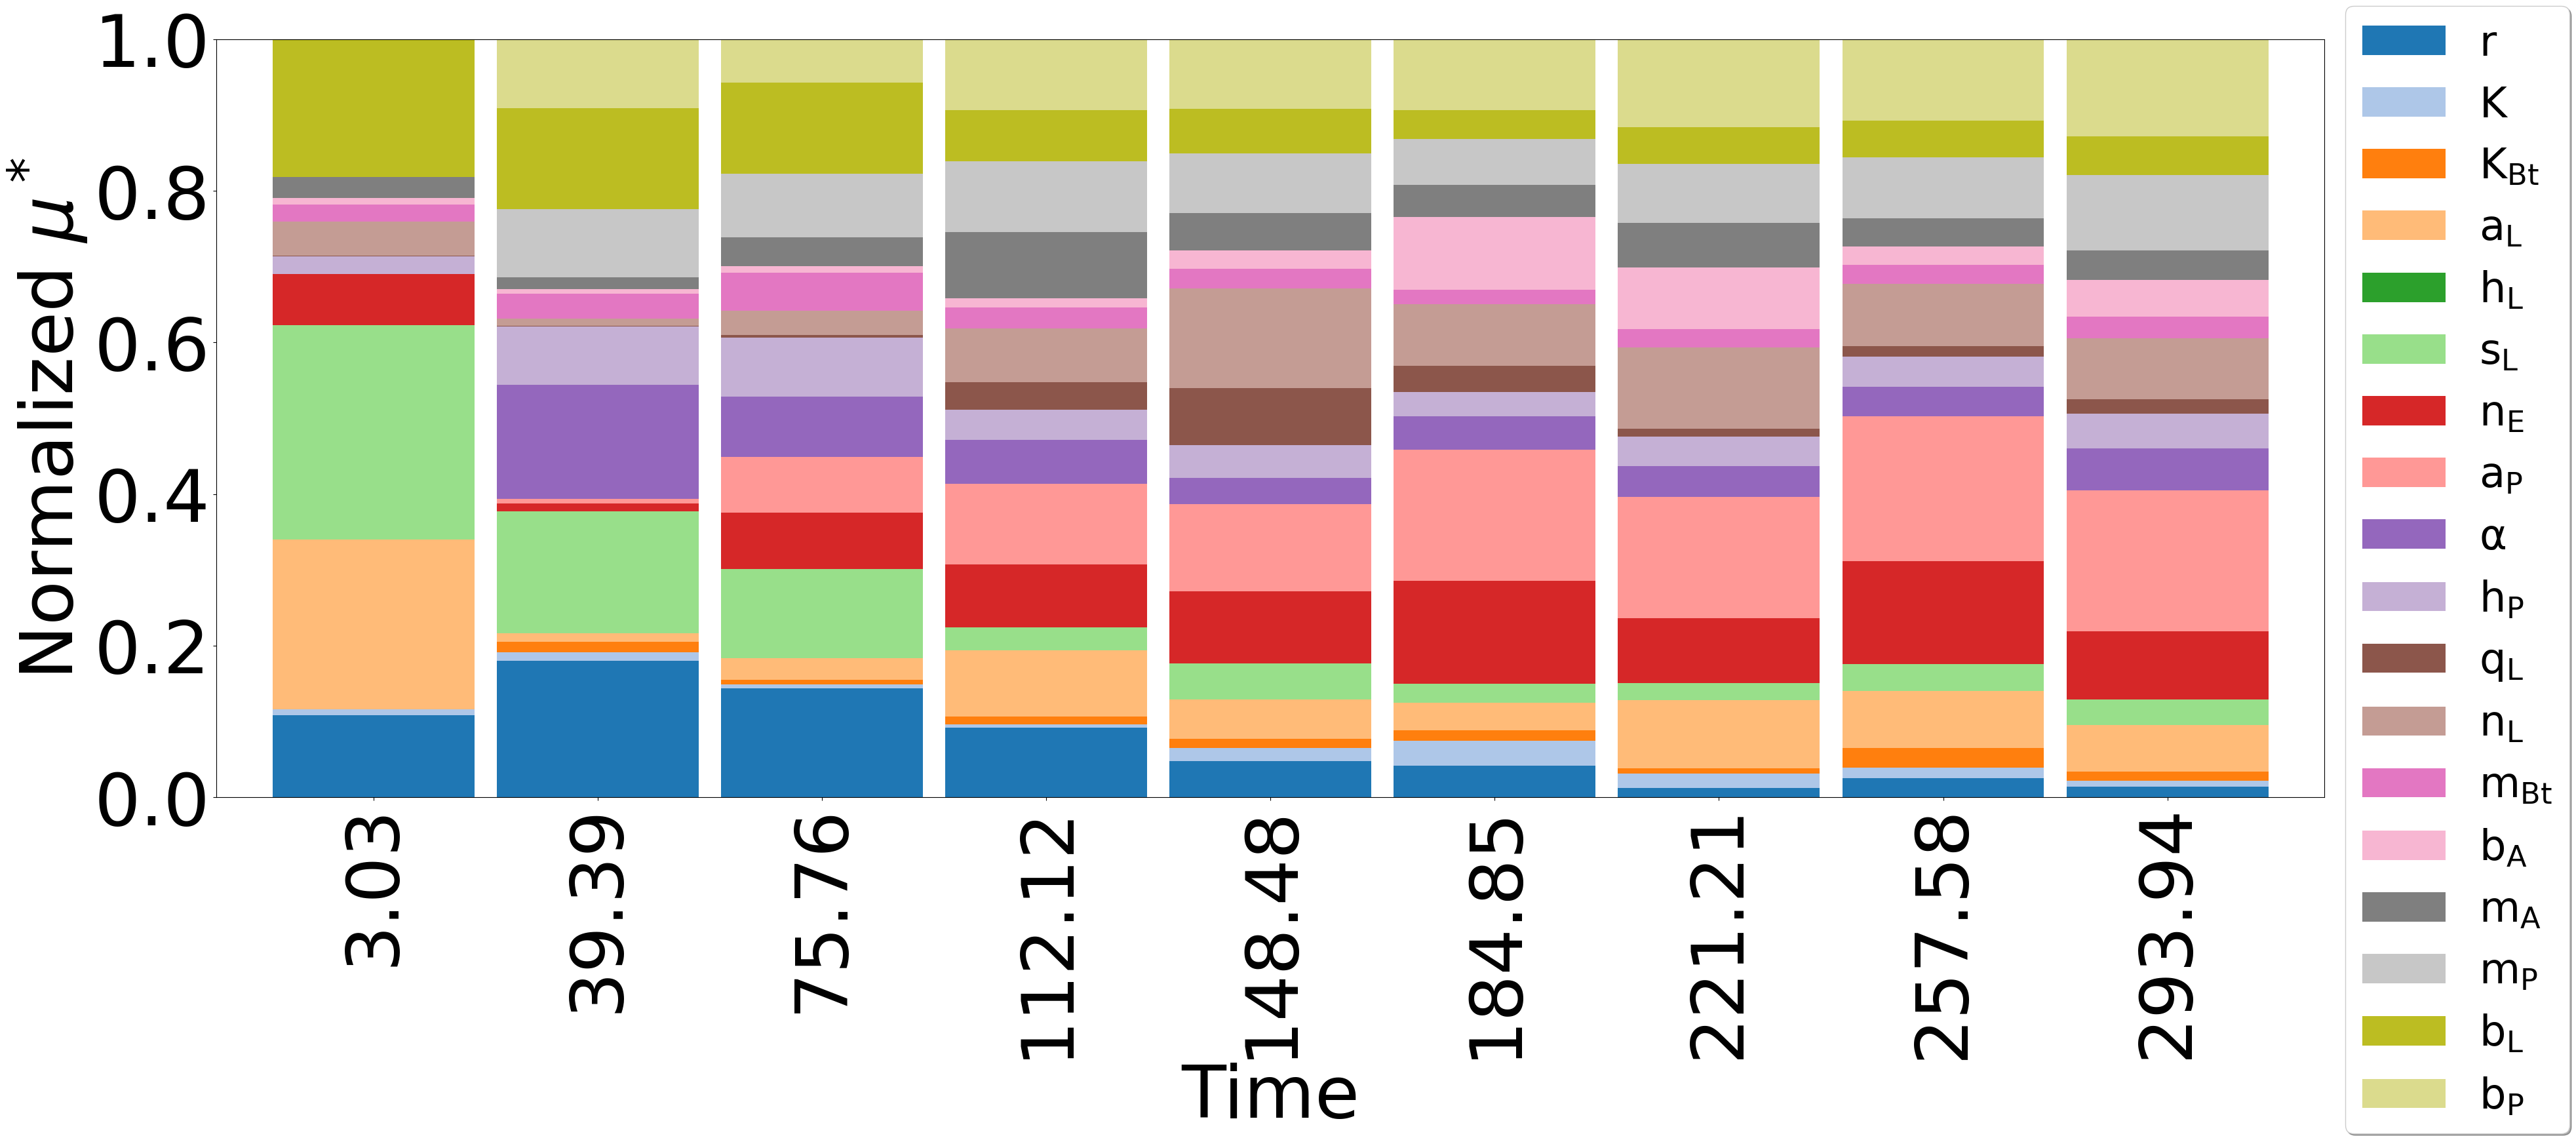

In [19]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]

colors =  plt.cm.tab20( (3./3*np.arange(24*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\mu^*$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.3), ncol=1, fancybox=True, shadow=True, fontsize=46)

plt.tight_layout()
plt.savefig("img/all_mixed_SA_structured_parasitism_mu.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

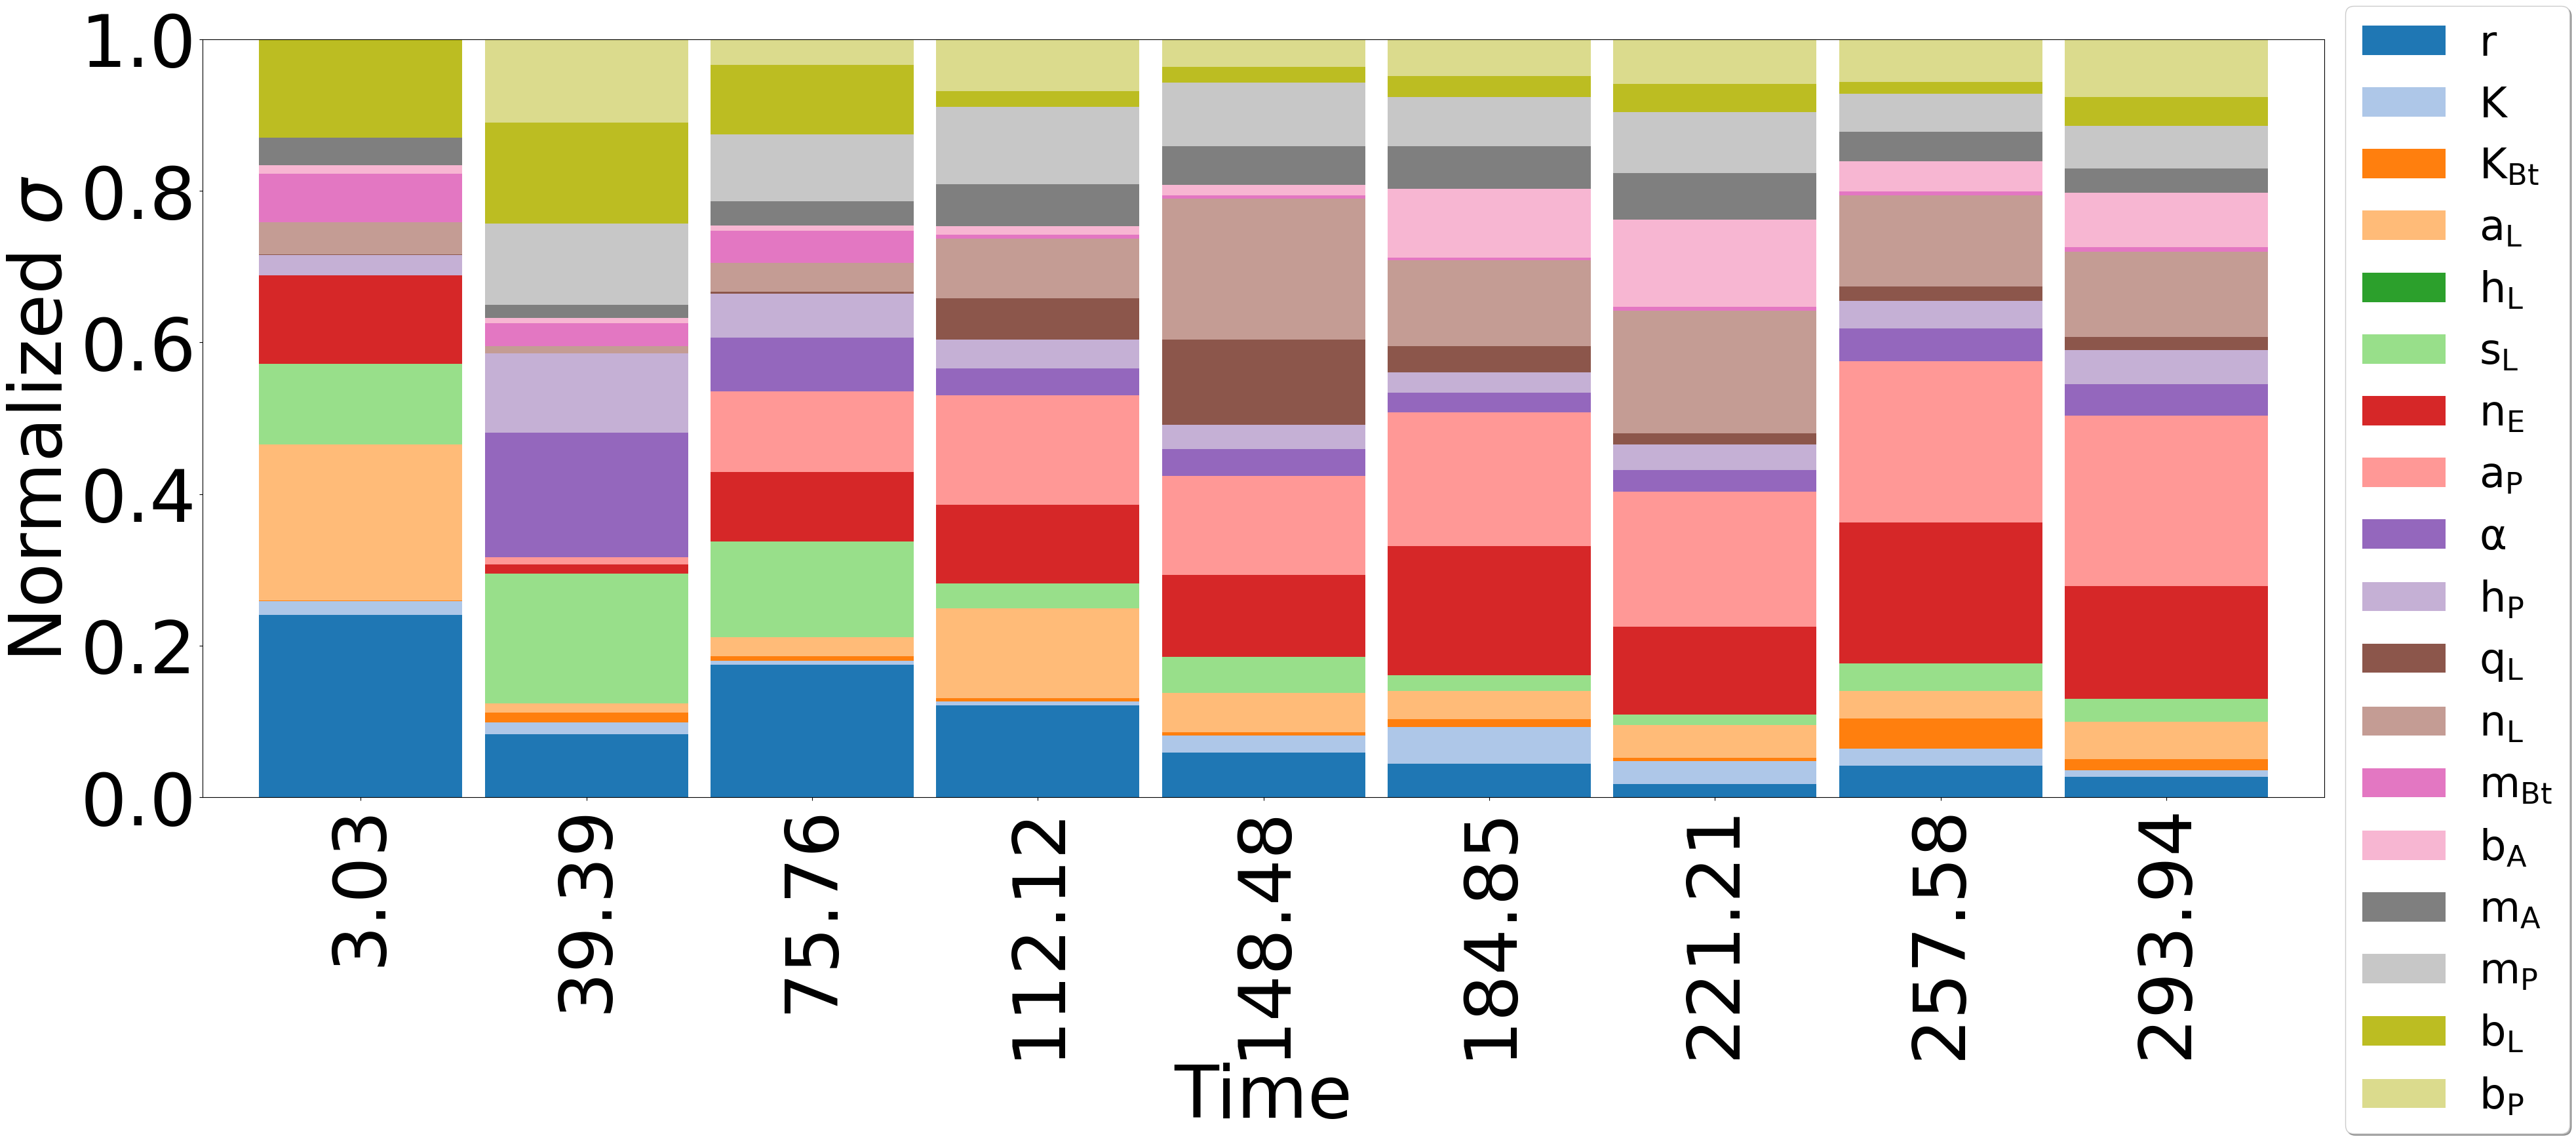

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]

colors =  plt.cm.tab20( (3./3*np.arange(24*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\sigma$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.3), ncol=1, fancybox=True, shadow=True, fontsize=46)

plt.tight_layout()
plt.savefig("img/all_mixed_SA_structured_parasitism_sigma.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

# Continuation diagram

In [21]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rcParams.update({'font.size': BIGGER_SIZE})

tmax = 10000
step = tmax*10
time_list = np.linspace(0, tmax, step)

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})
plt.rcParams['figure.constrained_layout.use'] = True

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Repeat cell 5

In [22]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    KBt=KBt,
    aL=aL,
    hL=hL,
    sL=sL,
    nE=nE,
    aP=aP,
    alpha=alpha,
    hP=hP,
    qL=qL,
    nL=nL,
    mBt=mBt,
    bA=bA,
    mA=mA,
    mP=mP,
    bL=bL,
    bP=bP,
):
    C,CBt,E,EBt,L,LBt,A,P = X
#    C: crop
#    CBt: genetically modified Bt crop
#    E: egg pest
#    EBt: egg pest in CBt
#    L: larvae pest in C
#    LBt: larvae pest in CBt
#    A: adult moth pest
#    P: parasitoid of egg (biocontrol agent)
    C_prime=r*C*(1-C/K)-aL*C*nE*E/(1+hL*C)
    CBt_prime=r*CBt*(1-CBt/KBt)-aL*CBt*nE*EBt/(1+hL*CBt)
    E_prime=(C/(C+CBt))*sL*A-nE*E-aP*(E**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
    EBt_prime=(CBt/(C+CBt))*sL*A-nE*EBt-aP*(EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
    L_prime=bL*aL*C*nE*E/(1+hL*C)-qL*L**2-nL*L
    LBt_prime=bL*aL*CBt*nE*EBt/(1+hL*CBt)-qL*LBt**2-nL*LBt-mBt*LBt
    A_prime=bA*nL*(L+LBt)-mA*A
    RP=ddf(t,sig,A,bound)
    P_prime=bP*aP*(E**alpha+EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)-mP*P+RP
    return C_prime,CBt_prime,E_prime,EBt_prime,L_prime,LBt_prime,A_prime,P_prime

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    KBt=KBt,
    aL=aL,
    hL=hL,
    sL=sL,
    nE=nE,
    aP=aP,
    alpha=alpha,
    hP=hP,
    qL=qL,
    nL=nL,
    mBt=mBt,
    bA=bA,
    mA=mA,
    mP=mP,
    bL=bL,
    bP=bP,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,KBt,aL,hP,sL,nE,aP,alpha,hP,qL,nL,mBt,bA,mA,mP,bL,bP),
        method=method,
    )
    return solution_ODE_structured_parasitism

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

In [23]:
y_limits = [(None, None), (None, None), (None, None), (None, None), (None, None), (0, 2.5), (1.5, 4), (0, 25)]

Running continuation:   0%|                             | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_161522/3614341654.py:6: RuntimeWarning: overflow encountered in exp
  sigmat = 1.0 / (1.0 + np.exp(-(5 - t) / w))
Running continuation:  10%|██                  | 51/500 [00:05<00:51,  8.73it/s]/tmp/ipykernel_161522/63185712.py:34: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(C/(C+CBt))*sL*A-nE*E-aP*(E**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:35: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(CBt/(C+CBt))*sL*A-nE*EBt-aP*(EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:40: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=bP*aP*(E**alpha+EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)-mP*P+RP
Plotting results for P: 100%|█████████████████████| 8/8 [00:00<00:00, 56.60it/s]
/tmp/ipykernel_161522/1881626848.py:149: UserWarning: This figure was using constrained_layout

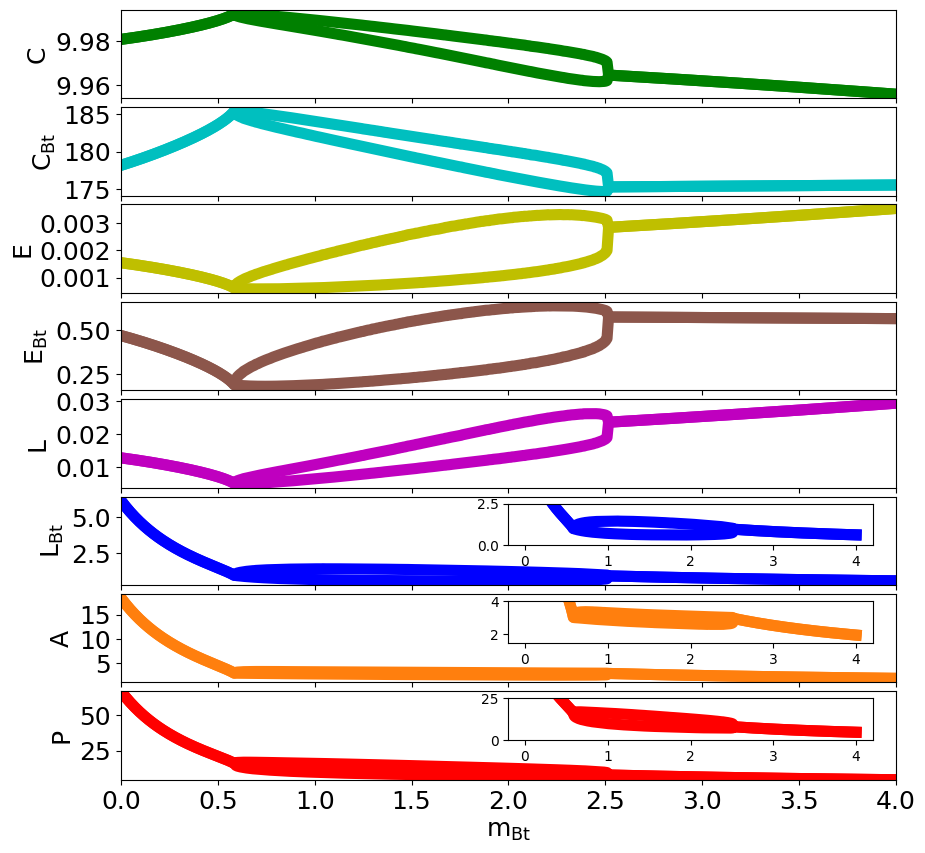

In [24]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            if np.isnan(output_variable_last_results[-1]):
                continue
            if output_variable_last_results[-1]<0:
                continue
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "KBt": KBt,
    "aL": aL,
    "hL": hL,
    "sL": sL,
    "nE": nE,
    "aP": aP,
    "alpha": alpha,
    "hP": hP,
    "qL": qL,
    "nL": nL,
#    "mBt": mBt,
    "bA": bA,
    "mA": mA,
    "mP": mP,
    "bL": bL,
    "bP": bP,
}


mBt_min = 0.0
mBt_max = 4.0
mBt_points = np.linspace(mBt_min, mBt_max, num_of_points)
parameter_to_continuation = {"mBt": mBt_points}

mBt_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="mBt",
    parameter_span=(mBt_min, mBt_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","A","P"],
    num_of_last_outcomes=1000,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
results_progress_bar.set_description("Plotting results")
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, figsize=(10,10), sharex=True, gridspec_kw={"hspace": 0.1, 'wspace': 0.1}, tight_layout=True, constrained_layout=True)
for index, variable_name in enumerate(results_progress_bar):
    results_progress_bar.set_description(f"Plotting results for {variable_name}")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = np.min(variable_result)
    variable_max_values = np.max(variable_result)
    
    color = colors_list[index]
    ax = axs[index]
    ax.plot(
        mBt_values["mBt"], variable_result, color=color, linewidth=8, markersize=8
    )
    ax.set(xlabel=r"$\mathregular{m_{Bt}}$", ylabel=f"{variable_name}", xlim=(mBt_min, mBt_max))
    
    if y_limits[index] != (None, None):
        ax_inset = ax.inset_axes([0.5, 0.45, 0.47, 0.47])  # Adjust these values to position and size the inset axes
        ax_inset.tick_params(axis='both', which='major', labelsize=MEDIUM_SIZE)  # Adjust the font size of the labels in the inset axes
        ax_inset.plot(mBt_values["mBt"], variable_result, color=color, linewidth=8, markersize=8)
        ax_inset.set_ylim(y_limits[index])
#         ax.indicate_inset_zoom(ax_inset, linewidth=1, edgecolor='black')
    
#     # Fixing y axis scale
#     set_off_y_axis = 0.5  # increase or decrease according to your needs. Values between 0 and 1.
#     ax.set_ylim(
#         [set_off_y_axis * variable_min_values, (1 + set_off_y_axis) * variable_max_values]
#     )
    
#     ax.ticklabel_format(style='plain',useOffset=False)
#     ax.label_outer()
 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18
 
plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})
plt.rcParams['figure.constrained_layout.use'] = True

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.margins(x=0, y=0)
plt.subplots_adjust(hspace=0,wspace=0)
plt.tight_layout(pad=0)
plt.savefig("img/all_mixed_continuation_mBt.png", format='png', bbox_inches = "tight", dpi=300)
plt.show()

In [25]:
y_limits = [(9.99, 10), (185, 190), (0, 0.001), (0, 0.4), (0, 0.006), (0, 2), (1.5, 4), (0, 25)]

Running continuation:   0%|                             | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_161522/3614341654.py:6: RuntimeWarning: overflow encountered in exp
  sigmat = 1.0 / (1.0 + np.exp(-(5 - t) / w))
Running continuation:  35%|██████▋            | 176/500 [01:20<24:43,  4.58s/it]/tmp/ipykernel_161522/63185712.py:34: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(C/(C+CBt))*sL*A-nE*E-aP*(E**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:35: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(CBt/(C+CBt))*sL*A-nE*EBt-aP*(EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:40: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=bP*aP*(E**alpha+EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)-mP*P+RP
Plotting results for P: 100%|█████████████████████| 8/8 [00:00<00:00, 34.30it/s]
/tmp/ipykernel_161522/3722306172.py:153: UserWarning: This figure was using constrained_layout

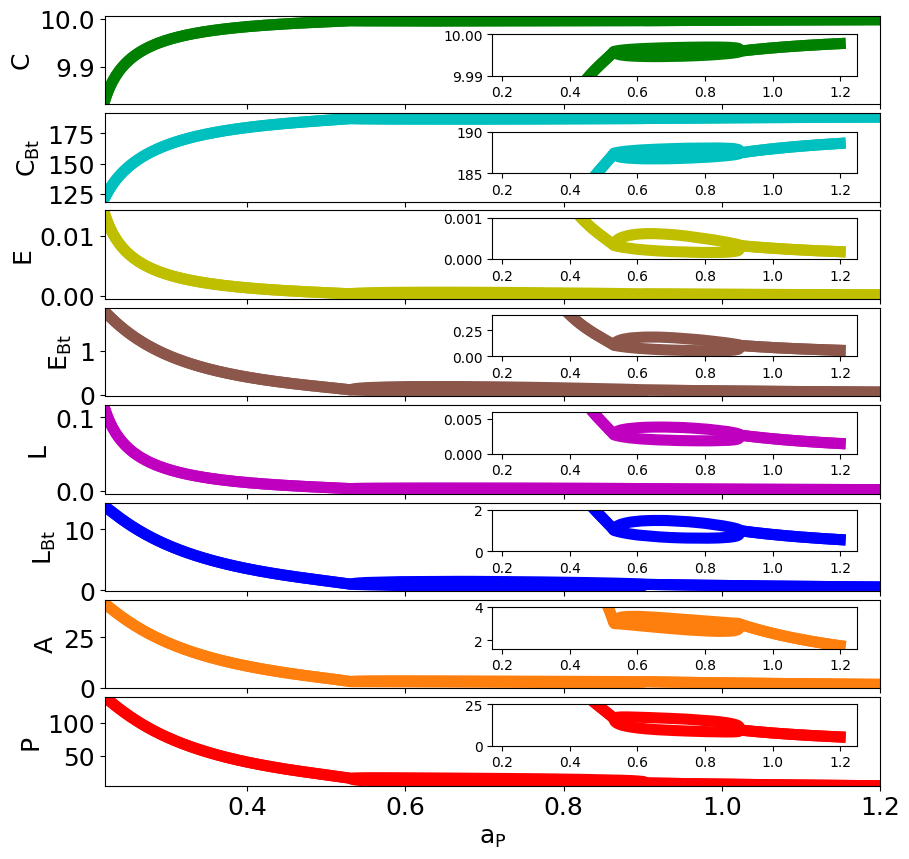

In [26]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            if np.isnan(output_variable_last_results[-1]):
                continue
            if output_variable_last_results[-1]<0:
                continue
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "KBt": KBt,
    "aL": aL,
    "hL": hL,
    "sL": sL,
    "nE": nE,
#    "aP": aP,
    "alpha": alpha,
    "hP": hP,
    "qL": qL,
    "nL": nL,
    "mBt": mBt,
    "bA": bA,
    "mA": mA,
    "mP": mP,
    "bL": bL,
    "bP": bP,
}


aP_min = 0.22
aP_max = 1.2
aP_points = np.linspace(aP_min, aP_max, num_of_points)
parameter_to_continuation = {"aP": aP_points}

aP_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="aP",
    parameter_span=(aP_min, aP_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","A","P"],
    num_of_last_outcomes=1000,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
results_progress_bar.set_description("Plotting results")
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, figsize=(10,10), sharex=True, gridspec_kw={"hspace": 0.1, 'wspace': 0.1}, tight_layout=True, constrained_layout=True)
for index, variable_name in enumerate(results_progress_bar):
    results_progress_bar.set_description(f"Plotting results for {variable_name}")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = np.min(variable_result)
    variable_max_values = np.max(variable_result)
    
    color = colors_list[index]
    ax = axs[index]
    ax.plot(
        aP_values["aP"], variable_result, color=color, linewidth=8, markersize=8
    )
    ax.set(xlabel=r"$\mathregular{a_P}$", ylabel=f"{variable_name}", xlim=(aP_min, aP_max))
    
    if y_limits[index] != (None, None):
        # Adjust the position of the inset for the first two variables
        if index < 2:  # for the first two variables
            ax_inset = ax.inset_axes([0.5, 0.32, 0.47, 0.47])  # Adjust these values to position and size the inset axes
        else:  # for the rest of the variables
            ax_inset = ax.inset_axes([0.5, 0.45, 0.47, 0.47])  # Adjust these values to position and size the inset axes
        ax_inset.tick_params(axis='both', which='major', labelsize=MEDIUM_SIZE)  # Adjust the font size of the labels in the inset axes
        ax_inset.plot(aP_values["aP"], variable_result, color=color, linewidth=8, markersize=8)
        ax_inset.set_ylim(y_limits[index])
#         ax.indicate_inset_zoom(ax_inset, linewidth=1, edgecolor='black')
    
    # Fixing y axis scale
#     set_off_y_axis = 0.5  # increase or decrease according to your needs. Values between 0 and 1.
#     ax.set_ylim(
#         [set_off_y_axis * variable_min_values, (1 + set_off_y_axis) * variable_max_values]
#     )
    
    ax.ticklabel_format(style='plain',useOffset=False)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})
plt.rcParams['figure.constrained_layout.use'] = True

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.margins(x=0, y=0)
plt.subplots_adjust(hspace=0,wspace=0)
plt.tight_layout(pad=0)
plt.savefig("img/all_mixed_continuation_aP.png", format='png', bbox_inches = "tight", dpi=300)
plt.show()

Running continuation:   0%|                             | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_161522/63185712.py:34: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(C/(C+CBt))*sL*A-nE*E-aP*(E**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:35: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(CBt/(C+CBt))*sL*A-nE*EBt-aP*(EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)
/tmp/ipykernel_161522/63185712.py:40: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=bP*aP*(E**alpha+EBt**alpha)*P/(1+hP*E**alpha+hP*EBt**alpha)-mP*P+RP
/tmp/ipykernel_161522/3614341654.py:6: RuntimeWarning: overflow encountered in exp
  sigmat = 1.0 / (1.0 + np.exp(-(5 - t) / w))
Plotting results for P: 100%|█████████████████████| 8/8 [00:00<00:00, 49.57it/s]
/tmp/ipykernel_161522/2371917242.py:144: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling c

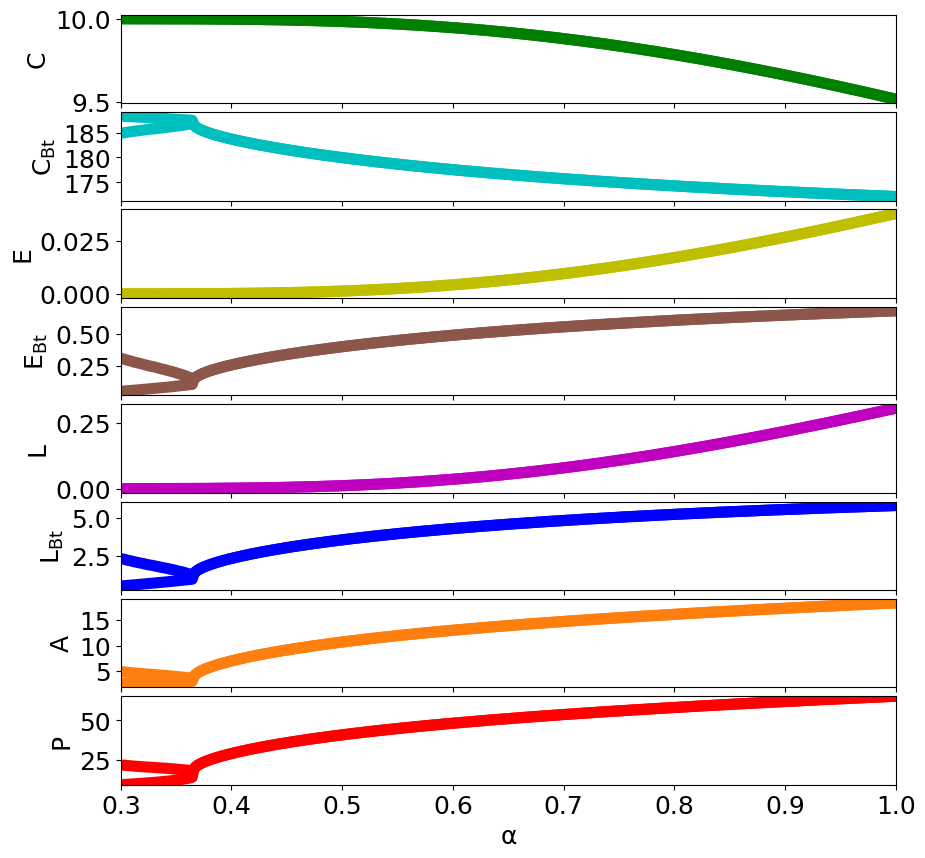

In [27]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            if np.isnan(output_variable_last_results[-1]):
                continue
#            print("antes: ",output_variable_last_results[-1])
            if output_variable_last_results[-1]<0:
                continue
#            print("depois: ",output_variable_last_results[-1])
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "KBt": KBt,
    "aL": aL,
    "hL": hL,
    "sL": sL,
    "nE": nE,
    "aP": aP,
#    "alpha": alpha,
    "hP": hP,
    "qL": qL,
    "nL": nL,
    "mBt": mBt,
    "bA": bA,
    "mA": mA,
    "mP": mP,
    "bL": bL,
    "bP": bP,
}


alpha_min = 0.3
alpha_max = 1.0
alpha_points = np.linspace(alpha_min, alpha_max, num_of_points)
parameter_to_continuation = {"alpha": alpha_points}

alpha_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="alpha",
    parameter_span=(alpha_min, alpha_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","A","P"],
    num_of_last_outcomes=1000,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
results_progress_bar.set_description("Plotting results")
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, figsize=(10,10), sharex=True, gridspec_kw={"hspace": 0.1, 'wspace': 0.1}, tight_layout=True, constrained_layout=True)
for index, variable_name in enumerate(results_progress_bar):
    results_progress_bar.set_description(f"Plotting results for {variable_name}")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = np.min(variable_result)
    variable_max_values = np.max(variable_result)
    
    color = colors_list[index]
    ax = axs[index]
    ax.plot(
        alpha_values["alpha"], variable_result, color=color, linewidth=8, markersize=8
    )
    ax.set(xlabel=r"$\mathregular{\alpha}$", ylabel=f"{variable_name}", xlim=(alpha_min, alpha_max))
    
    # Fixing y axis scale
#    set_off_y_axis = 0.5  # increase or decrease according to your needs. Values between 0 and 1.
#    ax.set_ylim(
#        [set_off_y_axis * variable_min_values, (1 + set_off_y_axis) * variable_max_values]
#    )
    
    ax.ticklabel_format(style='plain',useOffset=False)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})
plt.rcParams['figure.constrained_layout.use'] = True

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.margins(x=0, y=0)
plt.subplots_adjust(hspace=0,wspace=0)
plt.tight_layout(pad=0)
plt.savefig("img/all_mixed_continuation_alpha.png", format='png', bbox_inches = "tight", dpi=300)
plt.show()